In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
frames = np.load("frame_dataset.npy")

In [3]:
frames_train = frames[:100000]
frames_test = frames[600000:610000]

In [4]:
frames_train = np.nan_to_num(frames_train)
frames_test = np.nan_to_num(frames_test)

In [5]:
def conv_block(_input,_filters,_kernel,_pooling):
    c  = keras.layers.Conv1D(_filters,kernel_size = _kernel,padding="same",activation="relu")(_input)
    c  = keras.layers.Conv1D(_filters,kernel_size = _kernel,padding="same",activation="relu")(c)
    m  = keras.layers.MaxPooling1D(_pooling)(c)
    b  = keras.layers.BatchNormalization()(m)
    return b

In [6]:
def deconv_block(_input,_filters,_kernel,_strides,_pooling):
    c = keras.layers.Conv1DTranspose(_filters,kernel_size = _kernel,strides = _strides,activation="relu",padding="same")(_input)
    c = keras.layers.Conv1D(_filters,kernel_size = _kernel,padding="same",activation="relu")(c)
    b = keras.layers.BatchNormalization()(c)
    return b

In [14]:
def create_autoencoder():
    
    i = keras.layers.Input(shape = (96,))
    e = keras.layers.Reshape((96,1))(i)
    
    e = conv_block(_input = e,_filters = 8,_kernel = 3,_pooling = 2)
    #  48 x 48 x 16

    e = conv_block(_input = e,_filters = 16,_kernel = 3,_pooling = 2)
    #  24 x 24 x 32

    e = conv_block(_input = e,_filters = 32,_kernel = 3,_pooling = 2)    
    #  12 x 12 x 64

    e = conv_block(_input = e,_filters = 64,_kernel = 3,_pooling = 2)    
    #  6 x 6 x 128

    e = conv_block(_input = e,_filters = 64,_kernel = 3,_pooling = 2)    
    #  3 x 3 x 256

    e = keras.layers.Conv1D(16,kernel_size = 1,activation="tanh")(e)

    d = deconv_block(_input = e,_filters = 64 ,_kernel = 3,_strides = 2,_pooling = 2)
    #  6 x 6 x 128

    d = deconv_block(_input = d,_filters = 64 ,_kernel = 3,_strides = 2,_pooling = 2)
    #  12 x 12 x 64

    d = deconv_block(_input = d,_filters = 32 ,_kernel = 3,_strides = 2,_pooling = 2)
    #  24 x 24 x 32

    d = deconv_block(_input = d,_filters = 16 ,_kernel = 3,_strides = 2,_pooling = 2)
    #  48 x 48 x 16

    o = deconv_block(_input = d,_filters = 8 ,_kernel = 3,_strides = 2,_pooling = 2)
    #  96 x 96 x 1

    o = keras.layers.Conv1D(1, kernel_size = 1,activation="sigmoid")(o)
    
    model = keras.models.Model(inputs = i, outputs = o)
    model.compile(loss = keras.losses.binary_crossentropy,optimizer = keras.optimizers.Adam(1e-3))
    return model

In [15]:
model = create_autoencoder()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96)]              0         
                                                                 
 reshape_1 (Reshape)         (None, 96, 1)             0         
                                                                 
 conv1d_17 (Conv1D)          (None, 96, 8)             32        
                                                                 
 conv1d_18 (Conv1D)          (None, 96, 8)             200       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 48, 8)            0         
 1D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 48, 8)            32        
 chNormalization)                                          

In [22]:
model.fit(frames_train,frames_train,validation_data=(frames_test,frames_test),epochs=5,verbose = 1,shuffle = True)

Epoch 1/5
3125/3125 [==============================] - 39s 12ms/step - loss: 0.4537 - val_loss: 0.5255
Epoch 2/5
3125/3125 [==============================] - 38s 12ms/step - loss: 0.4529 - val_loss: 0.5391
Epoch 3/5
3125/3125 [==============================] - 39s 12ms/step - loss: 0.4528 - val_loss: 0.5277
Epoch 4/5
3125/3125 [==============================] - 38s 12ms/step - loss: 0.4519 - val_loss: 0.5265
Epoch 5/5
3125/3125 [==============================] - 38s 12ms/step - loss: 0.4516 - val_loss: 0.5245


In [23]:
predictions = model.predict(frames_test)

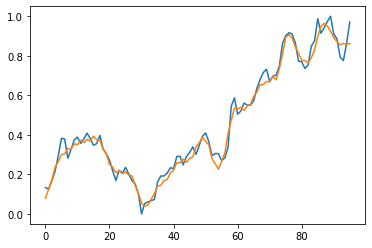

In [25]:
inn = random.randint(0,predictions.shape[0]-1)
plt.plot(frames_test[inn])
plt.plot(predictions[inn])

In [26]:
model.save("autoencoder")

INFO:tensorflow:Assets written to: autoencoder/assets
